In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
df= pd.read_excel("swainson's hawk.xlsx")
df['date'] = pd.to_datetime(df['date'])
df
# select points where month is January
print(df[df['date'].dt.month == 1])


             species birdID       date  longitude  latitude
24   Swainson's hawk   SW16 1997-01-24    -62.197   -31.829
25   Swainson's hawk   SW16 1997-01-30    -62.419   -31.659
112  Swainson's hawk   SW18 1997-01-03    -64.433   -35.081
113  Swainson's hawk   SW18 1997-01-15    -64.401   -35.212


In [3]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Calculate differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Calculate distance
    distance = R * c
    return distance

In [4]:
def migratory_stretch_estimator(df):
    # Calculate distance and time difference for each bird ID
    result_data = []

    # Iterate over each unique bird ID
    for bird_id, group_df in df.groupby('birdID'):
        first_entry = True
        # Calculate distance and time difference for each row in the group
        for index, row in group_df.iterrows():
            if first_entry:
                prev_longitude = row['longitude']
                prev_latitude = row['latitude']
                prev_date = row['date']
                first_entry = False
            else:
                distance = haversine(row['longitude'], row['latitude'], prev_longitude, prev_latitude)

                time_difference = (row['date'] - prev_date).days
                
                result_data.append({
                    'birdID': bird_id,
                    'distance': distance,
                    'time': time_difference
                })
                
                # Update previous values for the next iteration
                prev_longitude = row['longitude']
                prev_latitude = row['latitude']
                prev_date = row['date']

    # Create a new DataFrame from the result data
    result_df = pd.DataFrame(result_data)
    return result_df

In [5]:
def create_migration_network(data, max_migration, keep=True):
    groups = []
    for bird_id, group_df in data.groupby('birdID'):
        groups.append(group_df)

    # Create an empty graph
    migration_network = nx.Graph()

    # Iterate over each group of bird movements
    for bird_group in groups:
        # Extract latitude and longitude coordinates for the bird's movements
        points = list(zip(bird_group['latitude'], bird_group['longitude']))
        
        if keep:
            # Add edges based on the original connections
            for i in range(len(points) - 1):
                migration_network.add_edge(points[i], points[i + 1])
        else:
            # Add nodes to the network
            for point in points:
                migration_network.add_node(point)

    # Iterate again to add additional edges based on maximum migration distance
    all_nodes = migration_network.nodes()
    for node1 in all_nodes:
        for node2 in all_nodes:
            if node1 != node2:
                # Calculate distance between two nodes using Haversine formula
                distance = haversine(node1[0], node1[1], node2[0], node2[1])
                # If distance is less than max_migration, add an edge between the two nodes
                if distance < max_migration:
                    migration_network.add_edge(node1, node2)

    return migration_network

In [6]:
SWH_migratory_stretch = 676
SWH_median_migration = 165
SWH_mean_migration = 205

In [7]:
SWH_network = create_migration_network(df, SWH_migratory_stretch)
print(SWH_network)

Graph with 167 nodes and 1566 edges


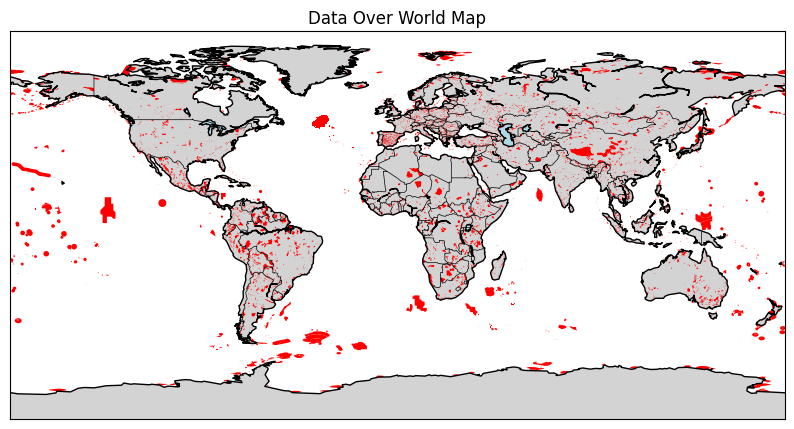

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import geopandas as gpd


# Read the world shapefile
world_map = Basemap()

# Create a figure and axis with Basemap projection
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.gca()

# Draw coastlines, countries, and continents
world_map.drawcoastlines()
world_map.drawcountries()
world_map.fillcontinents(color='lightgrey', lake_color='lightblue')

# Plot the data from the shapefile
# Replace 'path/to/data.shp' with the actual path to your shapefile
data = gpd.read_file('data/IBAsGlobal_2023_September_POL_02.shp')
data.plot(ax=ax, color='red', markersize=5)

# Add title
plt.title('Data Over World Map')

# Show the plot
plt.show()

In [9]:
from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd

def point_inside_polygon(latitude, longitude, df):
    # Create a shapely Point object from the latitude and longitude
    point = Point(longitude, latitude)
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the polygon geometry from the row
        geometry = row['geometry']
        
        # Check if the point is inside the polygon
        if point.within(geometry):
            # If inside, return True
            return True
    
    # If the point is not inside any polygon, return False
    return False

# Example usage:
# Assuming you have a DataFrame named 'data' containing the polygons
latitude = -12.056
longitude = -66.116
is_inside_polygon = point_inside_polygon(latitude, longitude, data)

print(f"The point ({latitude}, {longitude}) is inside a polygon: {is_inside_polygon}")

The point (-12.056, -66.116) is inside a polygon: False


In [10]:
# Calculate node betweenness centrality
betweenness_centrality = nx.betweenness_centrality(SWH_network)

lst=[]
# Print the node betweenness centrality values
for node, centrality in betweenness_centrality.items():
    lst.append([centrality,node])
    if(centrality>0.14):
        print(f"Important Node {node} with centraility = {centrality}")

Important Node (-31.451, -61.495) with centraility = 0.1600216453192016
Important Node (-12.056, -66.116) with centraility = 0.20706839409443817
Important Node (-6.011, -70.692) with centraility = 0.2507450834641664
Important Node (1.248, -74.331) with centraility = 0.3008657131377322
Important Node (16.873, -93.871) with centraility = 0.28650218116614684


In [37]:
def plot_migration_network_on_world_map(migration_network, betweenness_centrality):
    """
    Plot the migration network on a world map using latitude and longitude values for node positions.
    
    Parameters:
        - migration_network: NetworkX graph representing the migration network.
        - betweenness_centrality: Dictionary containing node betweenness centrality values.
    """
    # Create a new figure
    plt.figure(figsize=(10, 8))

    node_sizes =[]
    base_size = 10

    # Iterate over nodes and set their sizes based on centrality
    for node, centrality in betweenness_centrality.items():
        if centrality > 0.09:
            node_sizes.append(base_size * centrality * 100)  # Adjust the multiplier to control node size
        else:
            node_sizes.append(base_size)

    # Create a Basemap instance for world map projection
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)

    # Draw coastlines, countries, and states
    m.drawcoastlines()
    m.drawcountries()
    # m.drawstates()

    # Draw meridians and parallels
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert latitude and longitude coordinates to map coordinates
    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    # Define node colors based on centrality
    node_colors = ['red' if centrality > 0.09 else 'blue' for node, centrality in betweenness_centrality.items()]

    # Draw nodes with defined colors
    nx.draw_networkx_nodes(migration_network, pos, node_size=node_sizes, node_color=node_colors, alpha=0.5)

    # Draw edges
    nx.draw_networkx_edges(migration_network, pos, width=0.5, alpha=0.5)

    plt.title('Migration Network on World Map')
    plt.show()


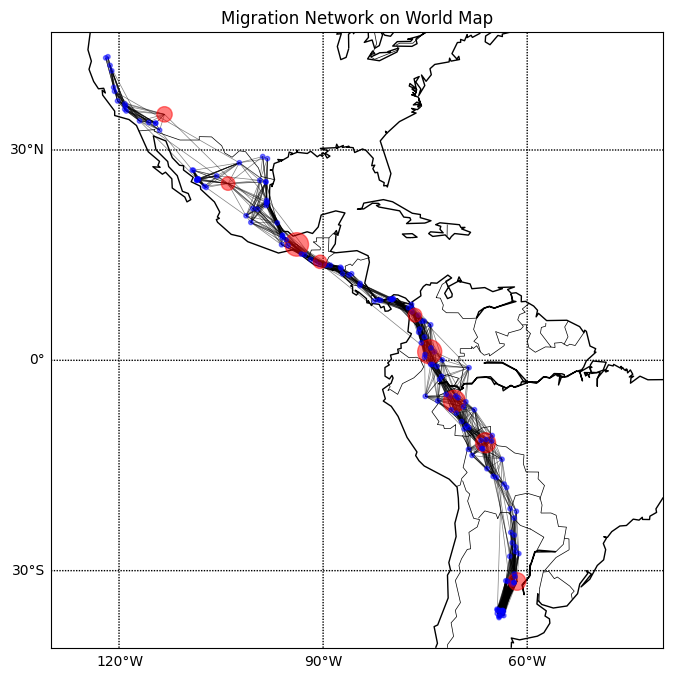

In [38]:
plot_migration_network_on_world_map(SWH_network, betweenness_centrality)


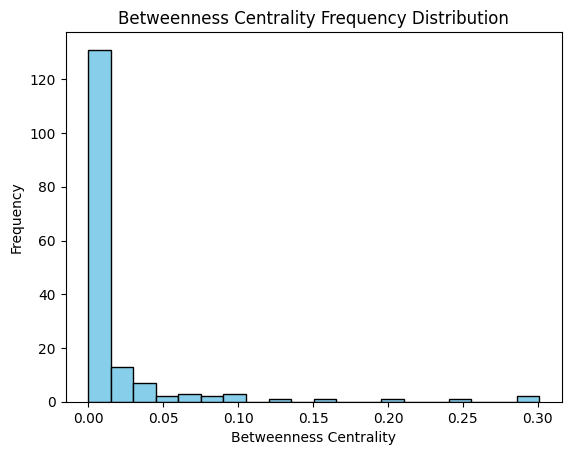

In [24]:
# betweenness_centrality frequency distribution plot
plt.hist(betweenness_centrality.values(), bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Betweenness Centrality Frequency Distribution')
plt.show()


In [13]:
nx.average_clustering(SWH_network)

0.7664280180088582

In [14]:
nx.degree_assortativity_coefficient(SWH_network)

0.6786947465572553

C:\Users\prath\AppData\Local\Temp\ipykernel_15276\1748640001.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


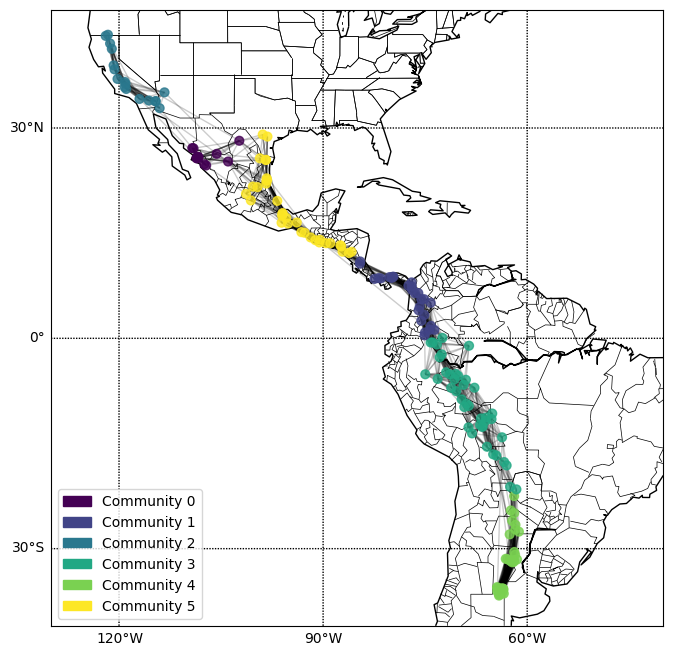

In [15]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm

'''
Figuring community structure in the migration network using the Louvain method.
Coloring the nodes according to their community structure.
Plotting the migration network on a world map using latitude and longitude values for node positions.
'''

plt.figure(figsize=(10, 8))

# Create a basemap of the American continents
m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Draw meridians and parallels
m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)
# Compute the best partition
partition = community_louvain.best_partition(SWH_network)

# Get the positions of the nodes
pos = {node: (node[1], node[0]) for node in SWH_network.nodes()}  # (lon, lat) to (lat, lon)

# Convert lat/lon to map projection coordinates
pos = {node: m(*position) for node, position in pos.items()}

# Color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(SWH_network, pos, node_size=40, cmap=cmap, node_color=list(partition.values()), alpha=0.8)
nx.draw_networkx_edges(SWH_network, pos, alpha=0.2)

# Create a legend
legend_labels = ["Community {}".format(i) for i in range(max(partition.values()) + 1)]
legend_handles = [mpatches.Patch(color=cmap(i / max(partition.values())), label=label) for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles, loc='lower left')

plt.show()

In [16]:
import networkx as nx

# Create or load your NetworkX graph
# Example: G = nx.read_edgelist("your_edgelist_file.txt")

# Compute closeness centrality for each node
closeness_centrality = nx.closeness_centrality(SWH_network)

# Print closeness centrality for each node
for node, centrality in closeness_centrality.items():
    if centrality > 0.30 and node[0]>10 :
        print(f"Node {node}: Closeness Centrality = {centrality}")


Node (16.873, -93.871): Closeness Centrality = 0.3287128712871287
Node (14.333, -91.134): Closeness Centrality = 0.3029197080291971
Node (14.384, -90.45): Closeness Centrality = 0.302367941712204


In [17]:
from math import radians, sin, cos, sqrt, asin
def find_closest_point(lat, lon):
    def haversine(lat1, lon1, lat2, lon2):
        # Convert coordinates to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * math.asin(sqrt(a))
        r = 6371  # Radius of the Earth in kilometers
        return c * r

    closest_point = None
    min_distance = float('inf')

    for index, row in data.iterrows():
        point_lat = row['SitLat']
        point_lon = row['SitLong']
        distance = haversine(lat, lon, point_lat, point_lon)
        if distance < min_distance:
            min_distance = distance
            closest_point = row['IntName']

    return closest_point, min_distance

# Example usage:
point_name, min_dist = find_closest_point(14.333, -91.134) 
print("Closest point:", point_name)
print("Minimum distance:", min_dist)


Closest point: Antigua Guatemala
Minimum distance: 42.420232643420924


In [18]:
def plot_migration_network_on_world_map(migration_network, closeness_centrality):
    """
    Plot the migration network on a world map using latitude and longitude values for node positions.
    
    Parameters:
        - migration_network: NetworkX graph representing the migration network.
        - betweenness_centrality: Dictionary containing node betweenness centrality values.
    """
    # Create a new figure
    plt.figure(figsize=(10, 8))

    node_sizes =[]
    base_size = 10

    # Iterate over nodes and set their sizes based on centrality
    for node, centrality in closeness_centrality.items():
        if centrality > 0.3:
            node_sizes.append(base_size * centrality * 50)  # Adjust the multiplier to control node size
        else:
            node_sizes.append(base_size)

    # Create a Basemap instance for world map projection
    m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)

    # Draw coastlines, countries, and states
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Draw meridians and parallels
    m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
    m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

    # Convert latitude and longitude coordinates to map coordinates
    pos = {node: m(node[1], node[0]) for node in migration_network.nodes()}

    # Define node colors based on centrality
    node_colors = ['red' if centrality > 0.3 and (node[0]>0 and node[0]<10)  else 'green' if centrality > 0.3 and node[0]<0 else 'purple' if centrality>0.3 and node[0]>10 else 'blue' for node, centrality in closeness_centrality.items()]

    # Draw nodes with defined colors
    nx.draw_networkx_nodes(migration_network, pos, node_size=node_sizes, node_color=node_colors, alpha=0.5)

    # Draw edges
    nx.draw_networkx_edges(migration_network, pos, width=0.5, alpha=0.5)

    plt.title('Migration Network on World Map')
    plt.show()


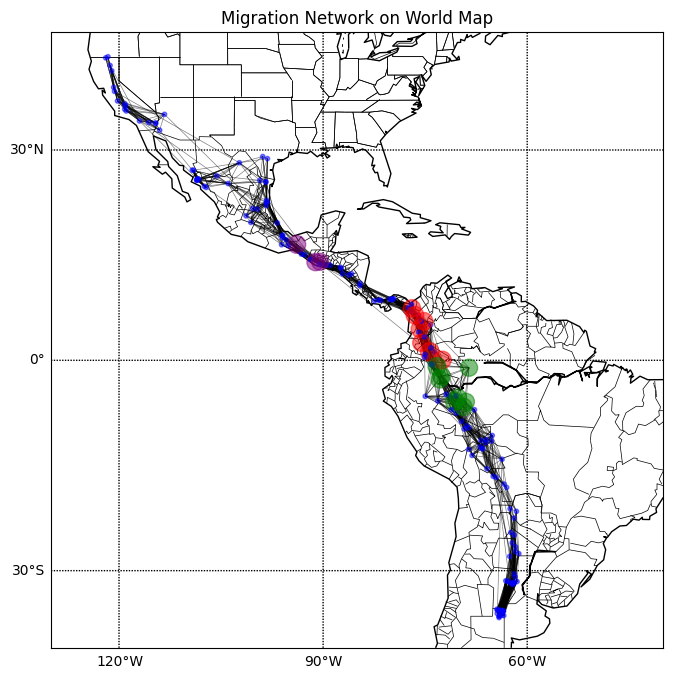

In [19]:
plot_migration_network_on_world_map(SWH_network, closeness_centrality)

In [20]:
import networkx as nx
from networkx.algorithms import community

# Create or load your NetworkX graph
# Example: G = nx.read_edgelist("your_edgelist_file.txt")

# Compute the modularity-based communities
communities = community.greedy_modularity_communities(SWH_network)

# Print the communities
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {comm}")

Community 1: frozenset({(16.873, -93.871), (21.875, -99.654), (13.895, -88.938), (22.85, -98.235), (4.609, -75.806), (14.333, -91.134), (11.255, -84.559), (-0.612, -74.192), (3.43, -75.102), (7.101, -76.928), (7.621, -76.95), (7.707, -77.466), (-0.613, -73.886), (5.753, -75.572), (1.829, -74.152), (8.832, -81.862), (13.9, -89.592), (15.395, -92.714), (17.831, -96.021), (8.785, -81.524), (-0.904, -73.269), (19.938, -96.737), (16.72, -95.17), (5.745, -75.149), (8.916, -79.887), (21.95, -100.339), (13.601, -87.456), (14.725, -91.832), (12.667, -87.144), (29.12, -98.877), (12.475, -86.21), (22.38, -98.355), (25.67, -98.411), (8.977, -80.23), (16.835, -96.107), (0.438, -75.083), (6.643, -76.006), (1.248, -74.331), (8.887, -79.943), (8.711, -82.452), (28.84, -98.184), (25.646, -98.416), (8.205, -76.994), (28.277, -102.317), (10.921, -84.588), (20.007, -100.626), (14.004, -90.551), (25.437, -103.972), (20.94, -101.334), (0.854, -75.031), (17.538, -95.427), (25.879, -99.299), (5.214, -74.183),

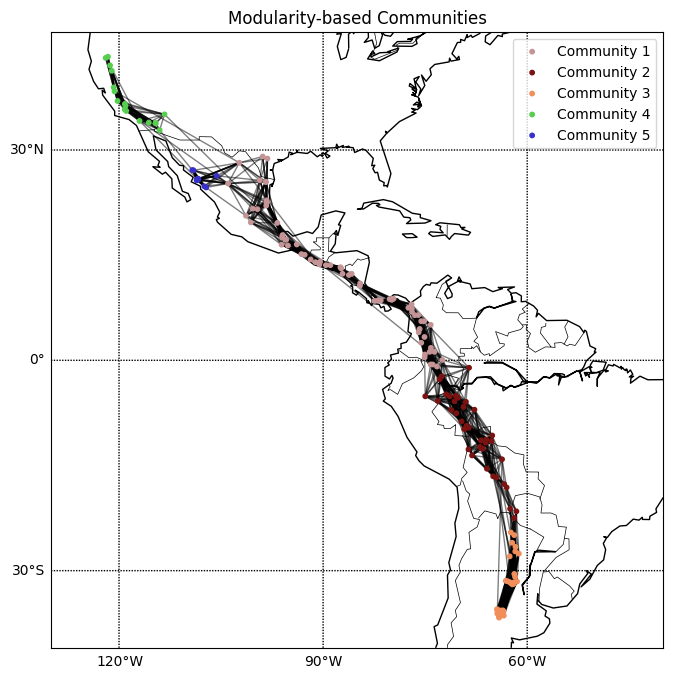

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import random

# Compute the modularity-based communities
communities = list(community.greedy_modularity_communities(SWH_network))
    # Create a Basemap instance for world map projection

plt.figure(figsize=(10, 8))
m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
# m.drawstates()

# Draw meridians and parallels
m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

pos = {node: m(node[1], node[0]) for node in SWH_network.nodes()}

# Create a color map for the nodes based on the communities
node_colors = {}
for i, comm in enumerate(communities):
    color = [random.random() for _ in range(3)]  # Generate a random RGB color for each community
    for node in comm:
        node_colors[node] = color

# Draw the graph with nodes colored based on communities

# pos = nx.spring_layout(SWH_network)  # Layout for the graph
for i, comm in enumerate(communities):
    nx.draw_networkx_nodes(SWH_network, pos=pos, nodelist=comm,node_size=10, node_color=[node_colors[node] for node in comm], label=f'Community {i+1}')
nx.draw_networkx_edges(SWH_network, pos, alpha=0.5)
plt.title('Modularity-based Communities')
plt.legend()
plt.show()


In [22]:
modularity_score = community.modularity(nx.Graph(SWH_network), communities)

print(f"Modularity: {modularity_score}")

Modularity: 0.6451805936821571


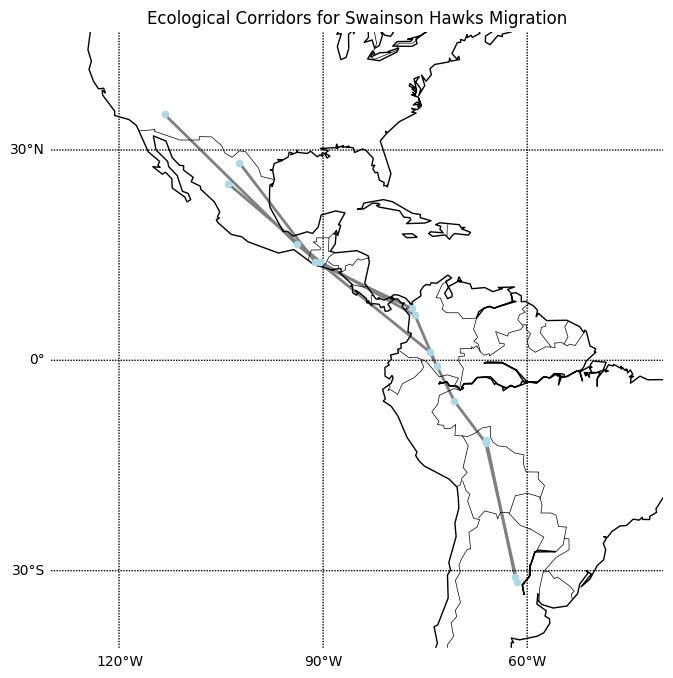

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming SWH_network is your NetworkX graph representing the Swainson Hawk migration network

# Compute edge betweenness centrality to identify potential corridors
edge_betweenness = nx.edge_betweenness_centrality(SWH_network)

# Threshold for edge betweenness centrality to identify corridors
threshold = 0.05  # Adjust as needed

# Identify edges with high betweenness centrality as potential corridors
corridor_edges = [edge for edge, centrality in edge_betweenness.items() if centrality > threshold]

# Create a subgraph consisting of potential corridor edges
corridor_network = SWH_network.edge_subgraph(corridor_edges)

# Visualize the corridor network
plt.figure(figsize=(10, 8))
m = Basemap(projection='mill', llcrnrlat=-40, urcrnrlat=45, llcrnrlon=-130, urcrnrlon=-40)

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
# m.drawstates()

# Draw meridians and parallels
m.drawmeridians(range(-180, 181, 30), labels=[0,0,0,1], fontsize=10)
m.drawparallels(range(-90, 91, 30), labels=[1,0,0,0], fontsize=10)

pos = {node: m(node[1], node[0]) for node in SWH_network.nodes()}
nx.draw(corridor_network,pos=pos, node_color='lightblue', node_size=20, edge_color='gray', width=2)
plt.title('Ecological Corridors for Swainson Hawks Migration')
plt.show()
